# Loading data

In [1]:
#%pip install gymnasium
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random

# Setting up the environment

In [2]:
env = gym.make("Pendulum-v1")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)


# Discretizing the observation space

In [3]:
import numpy as np
from collections import defaultdict

obs_bins = [
    np.linspace(-1, 1, 21),
    np.linspace(-1, 1, 21),
    np.linspace(-8, 8, 21),
]

action_vals = np.linspace(-2, 2, 17)

def discretize_observation(obs):
    return tuple(np.digitize(obs[i], obs_bins[i]) for i in range(len(obs)))


# Initializing the Q-Table

In [4]:
from collections import defaultdict

Q = defaultdict(lambda: np.zeros(len(action_vals)))

# Monte Carlo

In [5]:
num_episodes = 20000    
gamma = 0.99            #discount factor
alpha = 0.1             #learning rate
epsilon = 1.0           #initial exploration rate
epsilon_decay = 0.9995  #decay rate for epsilon
epsilon_min = 0.05      #minimum exploration rate

returns = []
window = 100

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs)
    trajectory = []
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(len(action_vals))
        else:
            action_idx = np.argmax(Q[state])

        action = np.array([action_vals[action_idx]])
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs)

        trajectory.append((state, action_idx, reward))
        state = next_state
        done = terminated or truncated

    G = 0
    visited = set()
    for t in reversed(range(len(trajectory))):
        s, a, r = trajectory[t]
        G = r + gamma * G
        if (s, a) not in visited:
            Q[s][a] += alpha * (G - Q[s][a])
            visited.add((s, a))

    episode_return = sum(r for _, _, r in trajectory)
    returns.append(episode_return)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 1000 == 0:
        avg_return = np.mean(returns[-window:])
        print(f"Episode {episode + 1}, average return (last {window}): {avg_return:.2f}")

Episode 1000, average return (last 100): -1196.92
Episode 2000, average return (last 100): -1034.98
Episode 3000, average return (last 100): -681.75
Episode 4000, average return (last 100): -550.34
Episode 5000, average return (last 100): -446.64
Episode 6000, average return (last 100): -482.37
Episode 7000, average return (last 100): -366.89
Episode 8000, average return (last 100): -320.54
Episode 9000, average return (last 100): -371.42
Episode 10000, average return (last 100): -280.45
Episode 11000, average return (last 100): -375.81
Episode 12000, average return (last 100): -386.11
Episode 13000, average return (last 100): -282.56
Episode 14000, average return (last 100): -333.07
Episode 15000, average return (last 100): -285.58
Episode 16000, average return (last 100): -322.28
Episode 17000, average return (last 100): -348.28
Episode 18000, average return (last 100): -268.26
Episode 19000, average return (last 100): -301.78
Episode 20000, average return (last 100): -319.20


## Evaluation 

In [6]:
eval_episodes = 1000
total_return = 0.0

for _ in range(eval_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs)
    done = False
    G = 0
    while not done:
        action_idx = np.argmax(Q[state])
        action = np.array([action_vals[action_idx]])
        obs, reward, terminated, truncated, _ = env.step(action)
        state = discretize_observation(obs)
        G += reward
        done = terminated or truncated
    total_return += G

average_return = total_return / eval_episodes
print(f"Average return over {eval_episodes} eval episodes: {average_return:.2f}")

Average return over 1000 eval episodes: -314.45


## Plotting the metrics

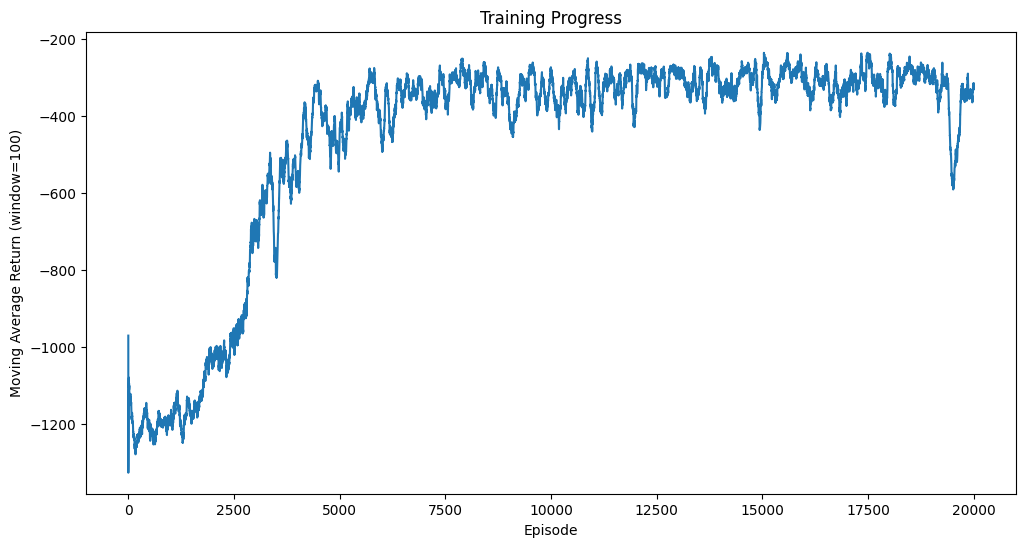

In [7]:
moving_avg = [np.mean(returns[max(0, i - window):i + 1]) for i in range(len(returns))]
plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("Training Progress")
plt.show()

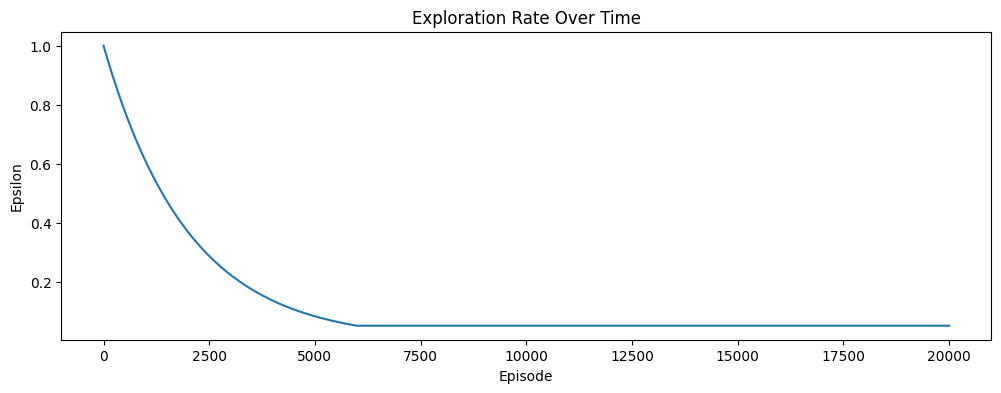

In [8]:
epsilons = [max(epsilon_min, 1.0 * (epsilon_decay ** i)) for i in range(num_episodes)]
plt.figure(figsize=(12, 4))
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Rate Over Time")
plt.show()

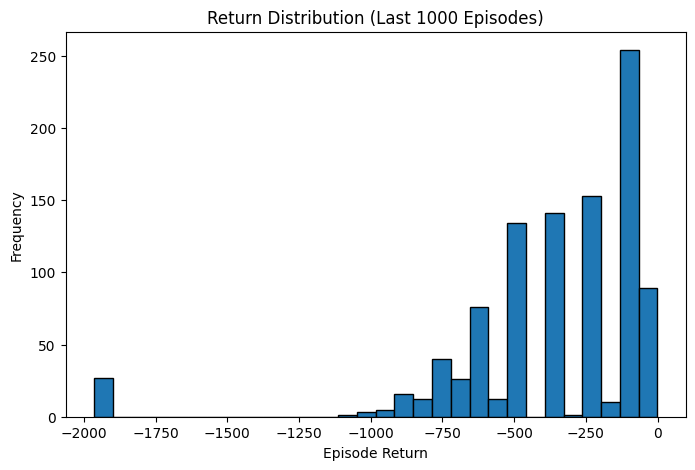

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(returns[-1000:], bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (Last 1000 Episodes)")
plt.show()

# Q-Learning

Q-Learning is a model-free algorithm in which the "[...] agent builds a Q-table which stores Q-values. Each Q-value estimates how good it is to take a specific action in a given state in terms of the expected future rewards. Over time the agent updates this table using the feedback it receives from the environment." (GeeksforGeeks, 2025)

In [ ]:
# Hyperparameters
alpha = 0.85         # learning rate
gamma = 0.9        # discount factor
epsilon = 1.0       # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.05
n_episodes = 1000
max_steps = 200

episode_rewards = []

for episode in range(n_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs)
    total_reward = 0

    for step in range(max_steps):
        # ε-greedy action selection
        if random.random() < epsilon:
            action_idx = random.randint(0, len(action_vals) - 1)
        else:
            action_idx = np.argmax(Q[state])

        action = [action_vals[action_idx]]  # Env expects action as list

        # Take step in the environment
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs)
        done = terminated or truncated

        # Q-learning update
        best_next_q = np.max(Q[next_state])
        td_target = reward + gamma * best_next_q
        td_delta = td_target - Q[state][action_idx]
        Q[state][action_idx] += alpha * td_delta

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay exploration rate
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay

    episode_rewards.append(total_reward)

    # Print progress
    if episode % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {episode}, Avg Reward (last 100): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

env.close()

Episode 0, Avg Reward (last 100): -1213.98, Epsilon: 0.995
Episode 100, Avg Reward (last 100): -1138.06, Epsilon: 0.603
Episode 200, Avg Reward (last 100): -991.42, Epsilon: 0.365
Episode 300, Avg Reward (last 100): -839.83, Epsilon: 0.221
Episode 400, Avg Reward (last 100): -759.33, Epsilon: 0.134
Episode 500, Avg Reward (last 100): -650.20, Epsilon: 0.081
Episode 600, Avg Reward (last 100): -599.26, Epsilon: 0.050
Episode 700, Avg Reward (last 100): -563.18, Epsilon: 0.050
Episode 800, Avg Reward (last 100): -504.17, Epsilon: 0.050
Episode 900, Avg Reward (last 100): -461.63, Epsilon: 0.050


The agent trained for 1000 episodes and the progress was monitored through average rewards over 100 episode windows, showing the learning progression from random performance to optimized policy.

## Evaluation

To better visualize learning trends and reduce the noise inherent in episodic rewards, the group applied a moving average smoothing with a window size of 50.

In [ ]:
def smooth(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

The first thing the group did was check the Total Reward per episode and there is a clear upward trend, meaning that learning is happening.

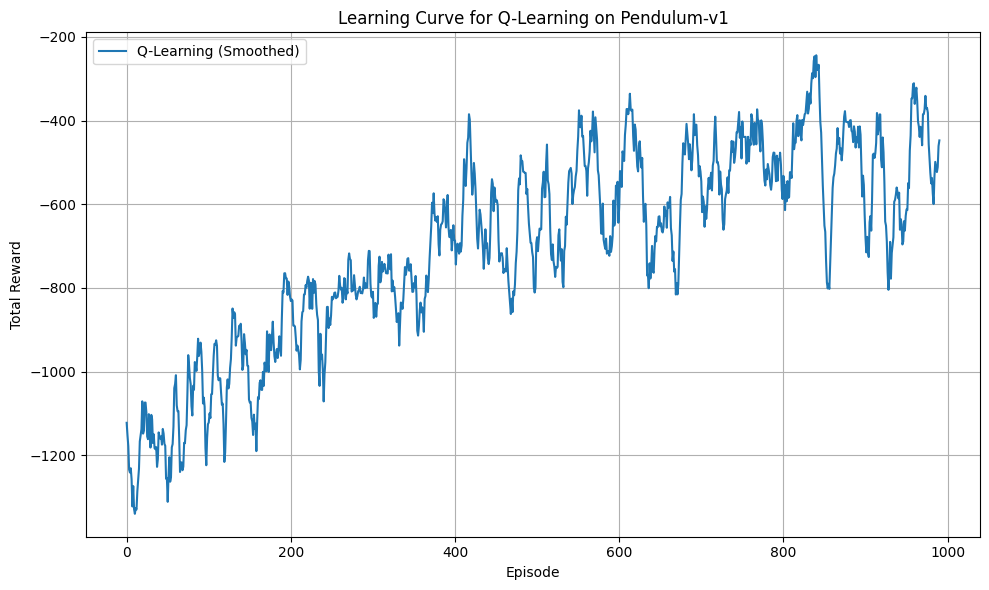

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(smooth(episode_rewards), label='Q-Learning (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve for Q-Learning on Pendulum-v1')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

To analyze and visualize the convergence speed, that tells how fast the agent improves, the group measured the episode number when the smoothed reward first exceeds a threshold (-600) for at least 10 consecutive episodes.

In [35]:
def find_convergence_episode(rewards, threshold=-600, patience=10):
    for i in range(len(rewards) - patience):
        if all(r > threshold for r in rewards[i:i+patience]):
            return i
    return None

In [36]:
smoothed_rewards = smooth(episode_rewards)

In [37]:
convergence_episode = find_convergence_episode(smoothed_rewards)
print(f"Convergence detected at episode: {convergence_episode}")

Convergence detected at episode: 410


In Q-learning, the Exploration/Exploration trade-off is controlled by the epsilon value in the epsilon-greedy policy, where:
- High epsilon → more exploration (random actions).
- Low epsilon → more exploitation (greedy actions from Q-table).

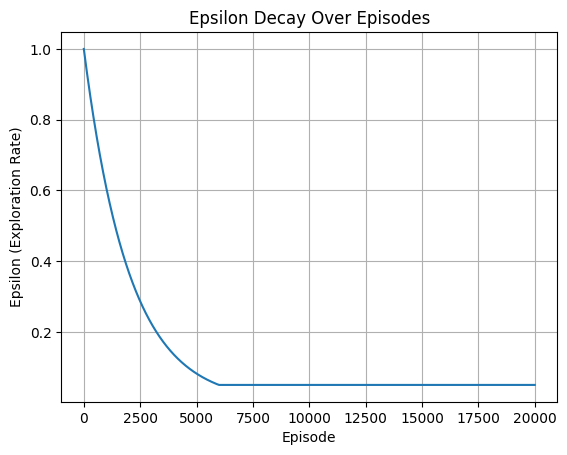

In [19]:
plt.plot(epsilons)
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Rate)")
plt.grid(True)

At the beginning of training, epsilon = 1.0, leading the agent to explore actions randomly. Over time, epsilon decayed exponentially to 0.01, allowing the agent to increasingly exploit the best known actions.
This balance allowed the agent to explore the action space early in training, and then stabilize performance through exploitation.

Next, the group visualized the learning progress through the success rate over time, accounting only for episodes with reward > -300 (smoothed over a 50-episode window).

In [38]:
import seaborn as sns

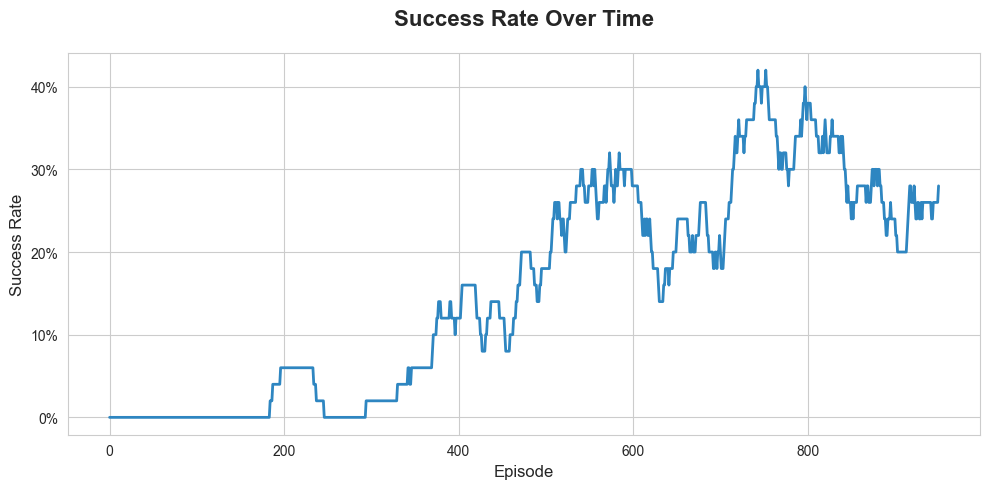

In [42]:
success_threshold = -300
success_rate = [1 if r > success_threshold else 0 for r in episode_rewards]
smoothed_success_rate = np.convolve(success_rate, np.ones(50)/50, mode='valid')


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


plt.figure(figsize=(10, 5))
plt.plot(smoothed_success_rate, linewidth=2, color='#2E86C1')

plt.title('Success Rate Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

It's possible to see that the first 200 episodes were the exploration phase, where the agent was performing random actions. The first successful episodes occurred around episode 200, with accelerated improvement until the best overall performance was achieved around episode 800. From this point, the performance started to degrade.